In [1]:
# Import Librarys
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron as SklearnPerceptron, SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
import ast


In [2]:
# X is features y is prediction (This for me to remember)
# Set pathing for base and validation sets (CHANGE THESE TO YOUR PATHINGS)
pa_path = r"C:\Users\andre\ML_Project_2\project_adult.csv"
pvi_path = r"C:\Users\andre\ML_Project_2\project_validation_inputs.csv"
output_path = r"C:\Users\andre\ML_Project_2"

# Read the files in
pa = pd.read_csv(pa_path)
pvi = pd.read_csv(pvi_path)

In [3]:
def preprocess_data_label(df):
    # Drop unnamed col
    df = df.drop(columns=['Unnamed: 0'], errors='ignore')

    # Handle missing values
    df = df.dropna()

    # Separate categorical and numeric columns
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    income_col = df['income'].copy()
    cat_cols.remove('income')
    num_cols = df.select_dtypes(exclude=['object']).columns.tolist()

    # Encode target
    income_col = income_col.map({'<=50K': -1, '>50K': 1})

    # One-hot encode categorical features
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    X_cat = ohe.fit_transform(df[cat_cols])
    cat_feature_names = list(ohe.get_feature_names_out(cat_cols))

    # Scale numeric features
    scaler = StandardScaler()
    X_num = scaler.fit_transform(df[num_cols])

    # Combine numeric + categorical into final DataFrame
    X_full = pd.DataFrame(
        data=np.hstack([X_num, X_cat]),
        columns=num_cols + cat_feature_names
    )

    # Add target column
    df_final = pd.concat([X_full, income_col.rename('income')], axis=1)

    X = X_full.values
    y = income_col.values.ravel()

    # Return features, target, transformers, and feature names
    return X, y, ohe, scaler, X_full.columns.tolist(), df_final


def preprocess_data_validation_label(df, ohe, scaler, feature_order):
    # Drop unnamed col
    df = df.drop(columns=['Unnamed: 0'], errors='ignore')

    # Handle missing values
    df = df.dropna()

    # Split cols
    cat_cols = [col for col in df.select_dtypes(include=['object']).columns if col in ohe.feature_names_in_]
    num_cols = df.select_dtypes(exclude=['object']).columns.tolist()

    # One-hot encode using fitted encoder
    X_cat = ohe.transform(df[cat_cols])
    cat_feature_names = list(ohe.get_feature_names_out(cat_cols))

    # Scale numeric features using fitted scaler
    X_num = scaler.transform(df[num_cols])

    # Combine numeric + categorical
    X_val_df = pd.DataFrame(
        data=np.hstack([X_num, X_cat]),
        columns=num_cols + cat_feature_names
    )

    # Reorder to match training feature order
    X_val_df = X_val_df.reindex(columns=feature_order, fill_value=0)
    X_val = X_val_df.values

    return X_val, X_val_df

In [4]:


# --- Training set preprocessing ---
X_train, y_train, ohe, scaler, feature_order, train_df = preprocess_data_label(pa)

print("Training set processed:")
print("Before shape:", pa.shape)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# --- Validation set preprocessing ---
X_val, val_df = preprocess_data_validation_label(pvi, ohe, scaler, feature_order)

print("\nValidation set processed:")
print("Before shape:", pvi.shape)
print("X_val shape:", X_val.shape)

Training set processed:
Before shape: (26048, 16)
X_train shape: (26048, 108)
y_train shape: (26048,)

Validation set processed:
Before shape: (6513, 15)
X_val shape: (6513, 108)


In [5]:
mlp = MLPClassifier(learning_rate='adaptive', shuffle=True, solver='adam', batch_size='auto', max_iter=100, learning_rate_init=0.0001)

param_grid = {
    'hidden_layer_sizes' : [(100,), (100, 10), (100, 50), (100, 100)],
    'activation' : ['identity', 'logistic', 'tanh', 'relu'],
    'alpha' : [0.001, 0.01, 0.1, 1]
}

grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


C:\Users\andre\anaconda3\envs\workspace\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=MLPClassifier(learning_rate='adaptive',
                                     learning_rate_init=0.0001, max_iter=100),
             n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': [0.001, 0.01, 0.1, 1],
                         'hidden_layer_sizes': [(100,), (100, 10), (100, 50),
                                                (100, 100)]},
             scoring='accuracy')

In [6]:
# Show best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Get best estimator
best_mlp = grid_search.best_estimator_


Best Parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100, 10)}
Best Cross-Validation Score: 0.855843241930676


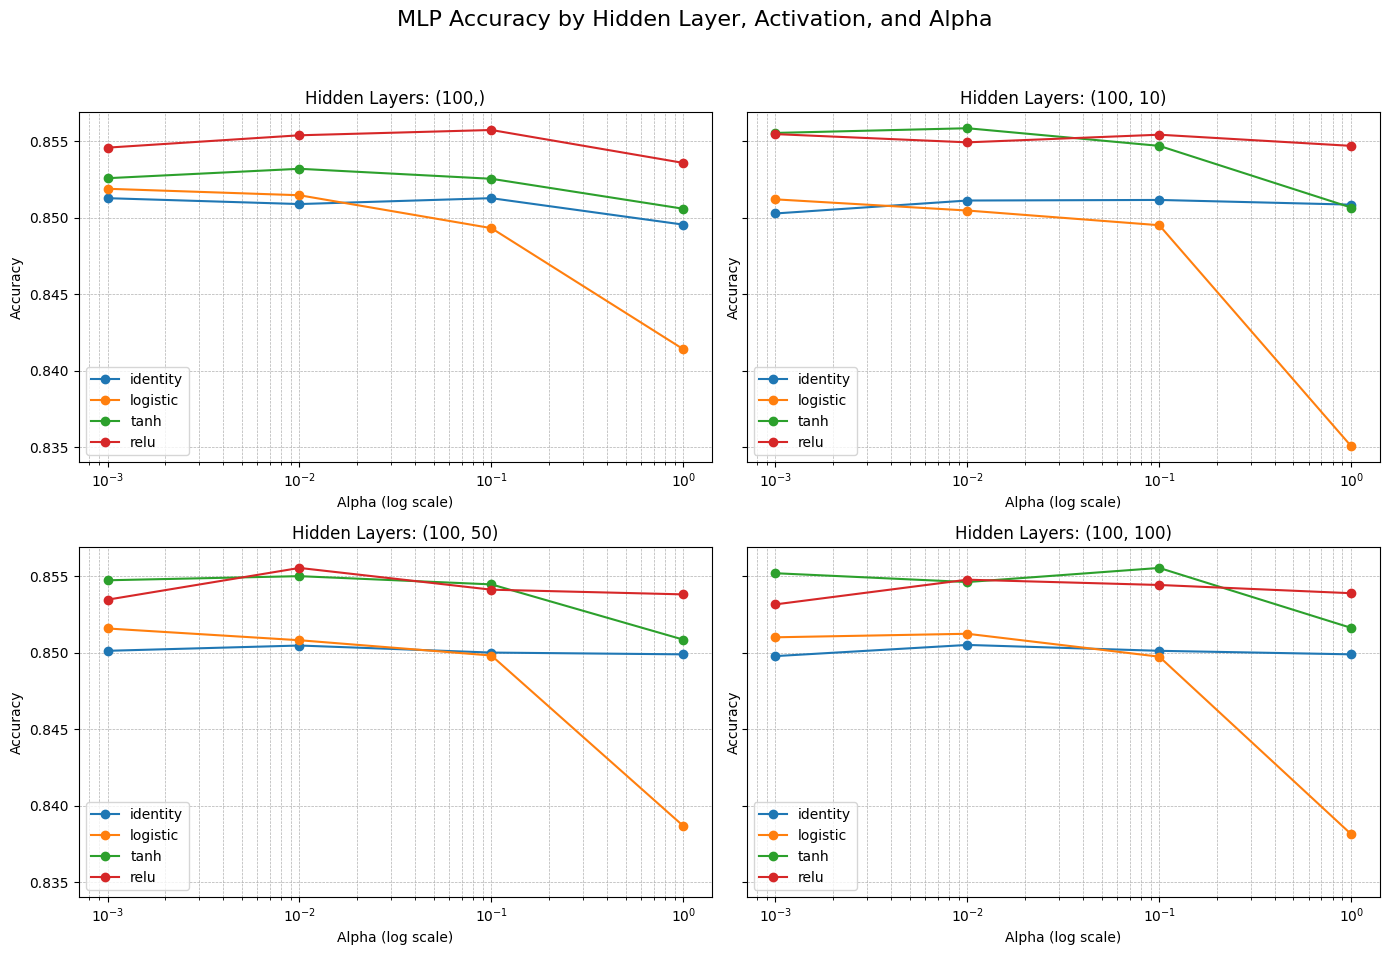

In [10]:
# Extract results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Plot setup
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
axes = axes.flatten()

# Unique hidden layer sizes in grid
layer_sizes = results['param_hidden_layer_sizes'].unique()

for i, layer in enumerate(layer_sizes):
    ax = axes[i]
    subset = results[results['param_hidden_layer_sizes'] == layer]

    for activation in param_grid['activation']:
        act_data = subset[subset['param_activation'] == activation]
        ax.plot(
            act_data['param_alpha'].astype(float),
            act_data['mean_test_score'],
            marker='o',
            label=activation
        )

    ax.set_title(f"Hidden Layers: {layer}")
    ax.set_xlabel("Alpha (log scale)")
    ax.set_ylabel("Accuracy")
    ax.set_xscale('log')
    ax.legend()
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.suptitle("MLP Accuracy by Hidden Layer, Activation, and Alpha", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
